In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [15]:
samples_base_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6"
cut = "lowen_looseVBS"
version = "v4"

samples_dir = os.path.join(samples_base_dir, cut, "samples", version)
model_dir   = os.path.join(samples_base_dir, cut, "models",  version)
import os 
os.makedirs(model_dir, exist_ok=True)


In [16]:
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [17]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

'mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 
'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 
'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 
'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww

In [20]:
import yaml
yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
print(type(yaml_vars), yaml_vars)
cols = yaml_vars

<class 'list'> ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta', 'deltaeta_vbs', 'deltaphi_vbs', 'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 'PuppiMET', 'nJets', 'N_jets_central', 'N_jets_forward', 'Zvjets_0', 'Zlep', 'Asym_vbs', 'Asym_vjet', 'A_ww', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'Centr_vbs', 'Centr_ww']


In [21]:
X_sig = signal[cols].values
X_bkg = bkg[cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight"]*signal["XSWeight_norm"]).values
W_bkg = (bkg["weight"]*bkg["XSWeight_norm"]).values

In [22]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

vjet_0_eta


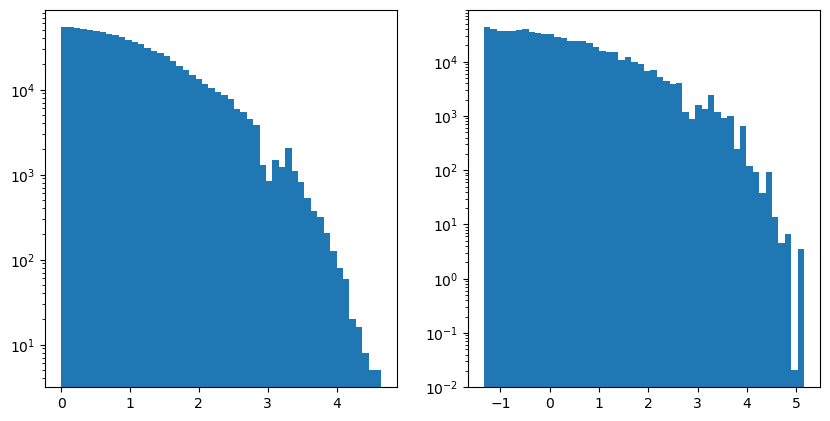

In [24]:
i = 10
print(cols[i])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
ax1.hist(X[:,i], bins=50)
ax1.set_yscale("log")
ax2.hist(X_scaled[:,i], weights=W, bins=50)
plt.yscale("log")

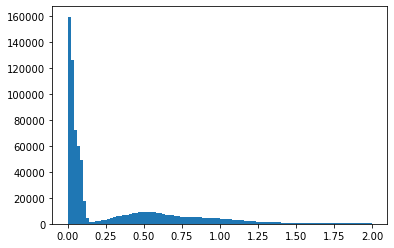

In [26]:
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [27]:
X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=0.2)
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=0.5)

In [28]:
print("Training dataset: ", X_train.shape)

Training dataset:  (697557, 32)


Create generators to balance signal and background

In [29]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [39]:
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.4))
#model.add(Dense(50, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               3300      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total para

In [40]:
auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)

In [41]:
## In case you do not want to use the generators
# history = model.fit(
#             X_train,y_train, 
#             sample_weight=W_train, 
#             epochs=50,
#             validation_data = (X_val, y_val, W_val),
#             batch_size=1024,
#             shuffle=True 
#             )

In [ ]:
history = model.fit_generator(
            training_generator, 
            epochs=500,
            #initial_epoch=200,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [], 
            )

Epoch 1/500
1168/1168 [==============================] - 11s 9ms/step - loss: 0.4750 - acc: 0.5509 - val_loss: 0.4504 - val_acc: 0.5698
Epoch 2/500
1168/1168 [==============================] - 11s 10ms/step - loss: 0.4537 - acc: 0.5700 - val_loss: 0.4458 - val_acc: 0.5815
Epoch 3/500
1168/1168 [==============================] - 11s 9ms/step - loss: 0.4482 - acc: 0.5809 - val_loss: 0.4435 - val_acc: 0.5939
Epoch 4/500
1168/1168 [==============================] - 11s 10ms/step - loss: 0.4435 - acc: 0.5849 - val_loss: 0.4423 - val_acc: 0.5933
Epoch 5/500
1168/1168 [==============================] - 10s 9ms/step - loss: 0.4406 - acc: 0.5893 - val_loss: 0.4408 - val_acc: 0.6007
Epoch 6/500
1168/1168 [==============================] - 10s 9ms/step - loss: 0.4373 - acc: 0.5927 - val_loss: 0.4400 - val_acc: 0.5917
Epoch 7/500
1168/1168 [==============================] - 11s 9ms/step - loss: 0.4324 - acc: 0.5911 - val_loss: 0.4339 - val_acc: 0.5960
Epoch 8/500
1168/1168 [=======================

In [ ]:
model.save(f"{model_dir}/model.h5")

>>> Computing AUC...


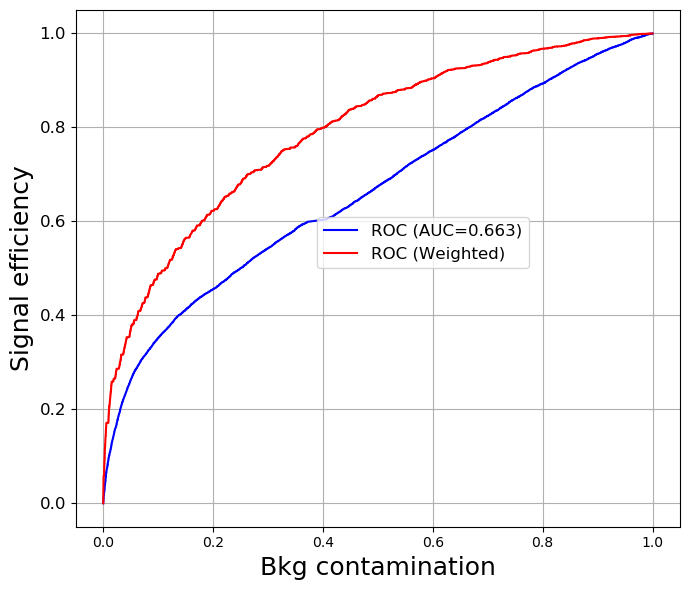

In [33]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test)
auc = roc_auc_score(y_test,pred)
fpW, tpW, thW = roc_curve(y_test, pred, sample_weight=W_test)
fp, tp, th = roc_curve(y_test, pred)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW, tpW, label=f"ROC (Weighted)", color="red")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

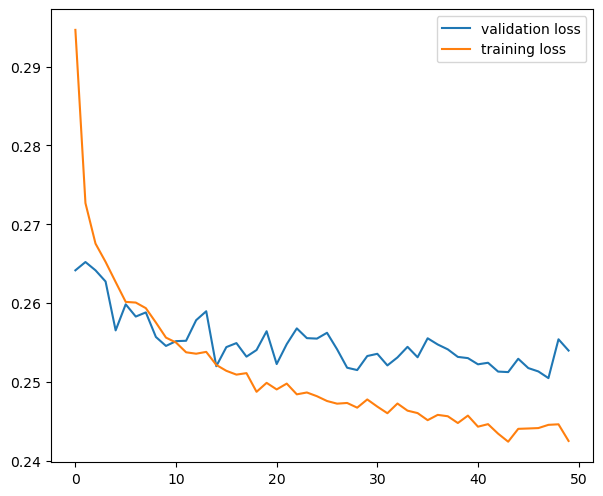

In [34]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

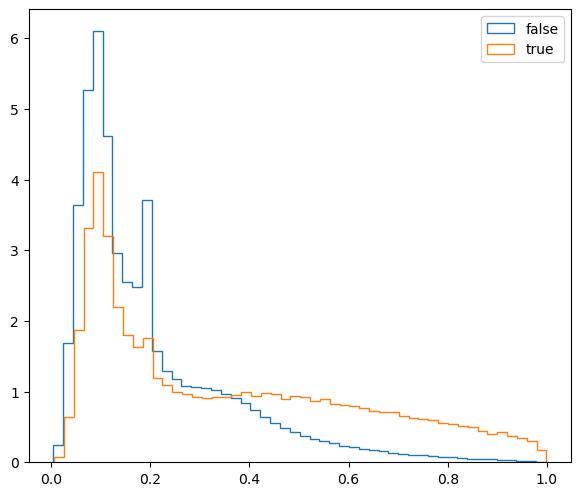

In [35]:
results = model.predict(X_train)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results[y_train==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_train==1], bins=50, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

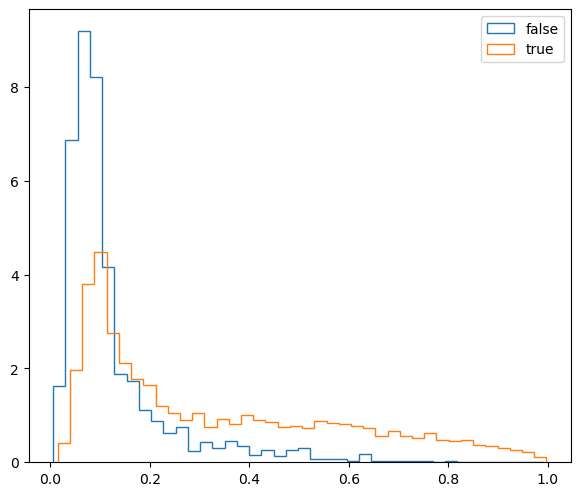

In [36]:
results = model.predict(X_test, batch_size=2048)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results[y_test==0],weights=W_test[y_test==0], bins=40,density=True, label="false", histtype="step")
plt.hist(results[y_test==1],weights=W_test[y_test==1], bins=40, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

## Evaluation by sample

In [76]:
bkg["y"] = model.predict(scaler.transform(bkg[cols].values), batch_size=2048)

In [77]:
signal["y"] = model.predict(scaler.transform(signal[cols].values), batch_size=2048)

In [78]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

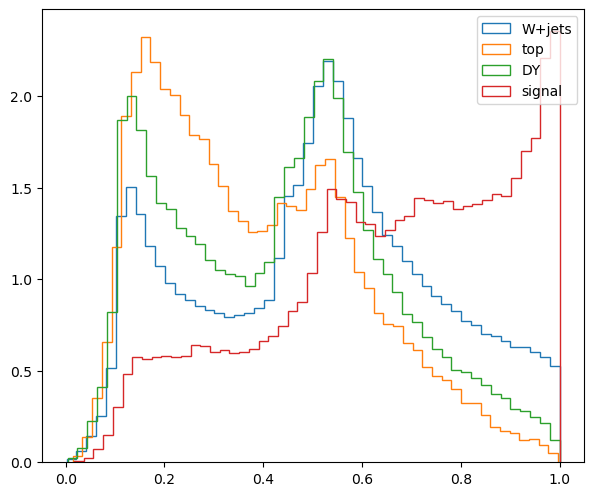

In [79]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

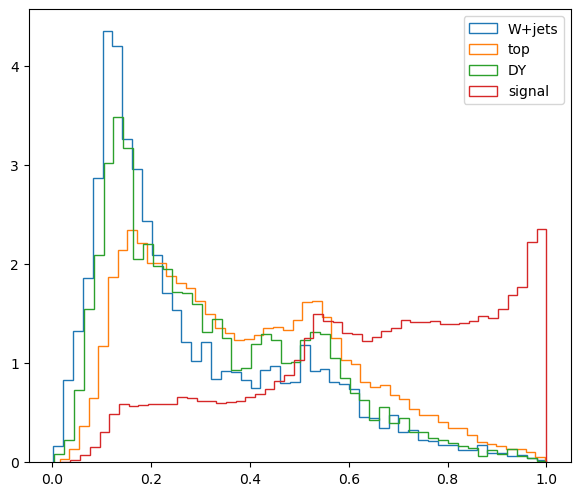

In [80]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.XSWeight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.XSWeight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.XSWeight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.XSWeight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()